# Intraday Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal

In [2]:
# Import data
df = pd.read_excel('hsi_price_data.xlsx', sheet_name = None)
df["Intraday_data"] = df["Intraday_data"][["Datetime", "HSI_Price"]]

## Data Cleaning

In [3]:
for i in df:
    print(i, df[i].isna().sum(), sep='\n', end = "\n"+"="*30+"\n" if i != list(df.keys())[-1] else "")

Intraday_data
Datetime     0
HSI_Price    0
dtype: int64
Interday_data
Date             0
Price          251
Unnamed: 2    9167
Unnamed: 3    9167
Unnamed: 4    9167
Unnamed: 5    9167
Unnamed: 6    9167
Unnamed: 7    9167
Unnamed: 8    9167
Unnamed: 9    9166
dtype: int64

In [4]:
for i in df:
    for j in df[i]:
        j != "Datetime" and j != "Date" and df[i][j].interpolate(method = 'linear', inplace = True)
df["Interday_data"].dropna(axis = 1, inplace = True)

In [5]:
for i in df:
    print(i, df[i].isna().sum(), sep='\n', end = "\n"+"="*30+"\n" if i != list(df.keys())[-1] else "")

Intraday_data
Datetime     0
HSI_Price    0
dtype: int64
Interday_data
Date     0
Price    0
dtype: int64

# Intraday_data

## Detrend

In [6]:
df1 = df["Intraday_data"]

In [7]:
df1.head()

,Datetime,HSI_Price
0,2023-01-16 09:30,21830.23047
1,2023-01-16 09:31,21871.35938
2,2023-01-16 09:32,21854.58008
3,2023-01-16 09:33,21831.43945
4,2023-01-16 09:34,21831.41016


<Axes: xlabel='Datetime'>

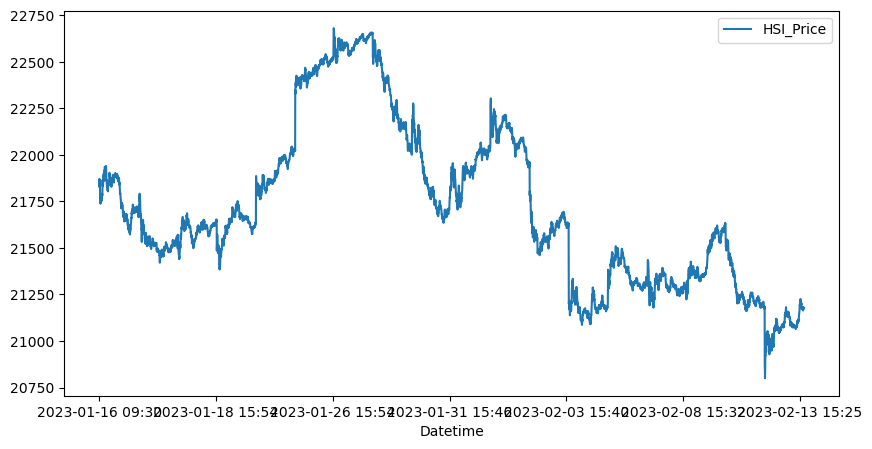

In [8]:
df1.plot(figsize = [10, 5], x = "Datetime", y = "HSI_Price")

In [9]:
df1.index = pd.to_datetime(df1.Datetime)

In [10]:
from scipy import signal
df1_detrended = signal.detrend(df1.HSI_Price)
df1_detrended = pd.DataFrame(df1_detrended, index = df1.index, columns = [df1.columns[1]])

In [11]:
df1_detrended.head()

,HSI_Price
Datetime,
2023-01-16 09:30:00,-261.264664
2023-01-16 09:31:00,-220.011426
2023-01-16 09:32:00,-236.666397
2023-01-16 09:33:00,-259.682699
2023-01-16 09:34:00,-259.587660


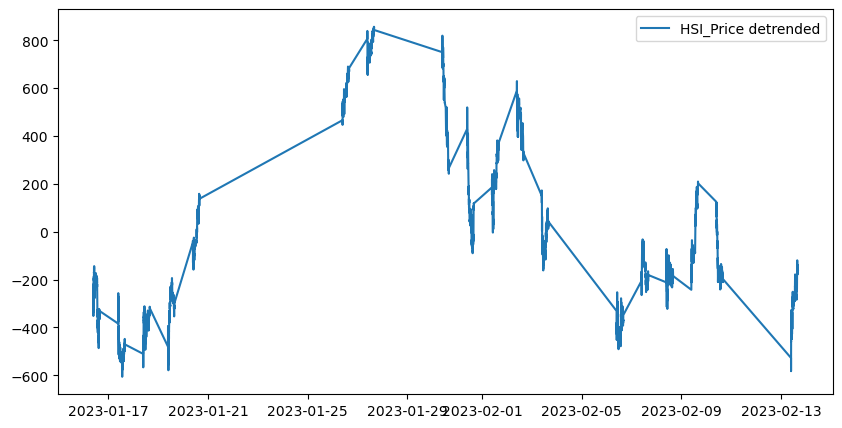

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df1_detrended.index, df1_detrended["HSI_Price"], label="HSI_Price detrended")
plt.legend(loc='best')
plt.show()

## 1-hot encoding

In [13]:
df1_detrended.head()

,HSI_Price
Datetime,
2023-01-16 09:30:00,-261.264664
2023-01-16 09:31:00,-220.011426
2023-01-16 09:32:00,-236.666397
2023-01-16 09:33:00,-259.682699
2023-01-16 09:34:00,-259.587660


In [14]:
df2 = df1_detrended.groupby([df1_detrended.index.date, df1_detrended.index.hour, np.where(df1_detrended.index.minute // 30, 1, 0)]).mean()

In [15]:
df2

HSI_Price
           Datetime              
2023-01-16 9        1 -299.164831
           10       0 -182.397215
                    1 -233.540016
           11       0 -210.721487
                    1 -190.677226
...                           ...
2023-02-13 13       1 -220.015577
           14       0 -263.664237
                    1 -274.370775
           15       0 -210.832847
                    1 -158.820895

[216 rows x 1 columns]

In [16]:
df2.index.names = ["date", "hour", "half_hour"]
df2.reset_index(inplace=True)

In [17]:
df2 = df2.loc[~((df2["hour"] == 12) & (df2["half_hour"] == 0))]

In [18]:
df2

,date,hour,half_hour,HSI_Price
0,2023-01-16,9,1,-299.164831
1,2023-01-16,10,0,-182.397215
2,2023-01-16,10,1,-233.540016
3,2023-01-16,11,0,-210.721487
4,2023-01-16,11,1,-190.677226
...,...,...,...,...
211,2023-02-13,13,1,-220.015577
212,2023-02-13,14,0,-263.664237
213,2023-02-13,14,1,-274.370775
214,2023-02-13,15,0,-210.832847


In [19]:
df2["hour"] = df2["hour"].astype(str)
df2["half_hour"] = df2["half_hour"].astype(str)
df2_dummies = pd.get_dummies(df2[["hour", "half_hour"]], columns=["hour", "half_hour"])

/var/folders/j0/5r4rz32s725cs8d72phm110m0000gn/T/ipykernel_59399/425026908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["hour"] = df2["hour"].astype(str)
/var/folders/j0/5r4rz32s725cs8d72phm110m0000gn/T/ipykernel_59399/425026908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["half_hour"] = df2["half_hour"].astype(str)


In [20]:
df2_dummies

,hour_10,hour_11,hour_13,hour_14,hour_15,hour_9,half_hour_0,half_hour_1
0,0,0,0,0,0,1,0,1
1,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
211,0,0,1,0,0,0,0,1
212,0,0,0,1,0,0,1,0
213,0,0,0,1,0,0,0,1
214,0,0,0,0,1,0,1,0


In [21]:
X = df2_dummies
y = df2["HSI_Price"]
modelA = sm.OLS(y, X).fit()

In [22]:
print(modelA.summary())

                            OLS Regression Results                            
Dep. Variable:              HSI_Price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                  0.009291
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               1.00
Time:                        04:09:29   Log-Likelihood:                -1454.3
No. Observations:                 198   AIC:                             2923.
Df Residuals:                     191   BIC:                             2946.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
hour_10         0.0474     59.042      0.001      

In [23]:
modelA.rsquared

0.00029178001726681835

In [24]:
modelA.params

hour_10        0.047396
hour_11       -5.085577
hour_13       -8.770055
hour_14       -0.578124
hour_15        9.764747
hour_9         6.286351
half_hour_0    0.116991
half_hour_1    1.547747
dtype: float64

In [25]:
df1.index = pd.to_datetime(df1.Datetime)
buy_mean = df1[(df1.index.hour == 13) & (df1.index.minute < 30)]['HSI_Price'].mean()
sell_mean = df1[(df1.index.hour == 15) & (df1.index.minute >= 30)]['HSI_Price'].mean()

In [26]:
# calculate sell-to-buy ratio
s2b_ratio = sell_mean / buy_mean
s2b_ratio

1.0003645369836294

## Optional method

In [27]:
q1 = 0.25
q2 = 0.75

In [28]:
formula = "HSI_Price ~ C(hour) + C(half_hour)"
model = smf.quantreg(formula, df2)

results = pd.DataFrame(columns=["quantile", "hour", "half_hour", "price"])

In [29]:
quantile_model = model.fit(q=q1)
params_1 = quantile_model.params
quantile_model = model.fit(q=q2)
params_2 = quantile_model.params
    
result = pd.concat([params_1, params_2], axis = 1)
result.columns = ["m1", "m2"]
result["Coef"] = result["m2"] - result["m1"]

result[["Coef"]]

,Coef
Intercept,607.220639
C(hour)[T.11],-130.764813
C(hour)[T.13],-163.553587
C(hour)[T.14],-9.418211
C(hour)[T.15],-43.008508
C(hour)[T.9],148.582490
C(half_hour)[T.1],16.773046


In [30]:
quantile_model = model.fit(q=q1)
r_1 = quantile_model.prsquared
quantile_model = model.fit(q=q2)
r_2 = quantile_model.prsquared
R_2 = r_2 + r_1
print("R-squared = {:.5f}".format(R_2))

R-squared = 0.01837


In [31]:
for q in [q1, q2]:
    quantile_model = model.fit(q=q)
    display(quantile_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:              HSI_Price   Pseudo R-squared:              0.01062
Model:                       QuantReg   Bandwidth:                       285.2
Method:                 Least Squares   Sparsity:                        869.5
Date:                Sun, 12 Mar 2023   No. Observations:                  198
Time:                        04:09:29   Df Residuals:                      191
                                        Df Model:                            6
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -338.3610     67.972     -4.978      0.000    -472.433    -204.289
C(hour)[T.11]        62.7236     88.743      0.707      0.481    -112.319     237.766
C(hour)[T.13]       107.0616     88.743      1.206      0.229     -67.981     282.104
C(hour)[T.14]        60.8980     90.371      0.674      0.501    -117.356     239.152
C(hour)[T.15]        27.7251     88.743      0.312      0.755    -147.317     202.767
C(hour)[T.9]        -28.4755    115.379     -0.247      0.805    -256.055     199.104
C(half_hour)[T.1]    -0.0561     56.540     -0.001      0.999    -111.580     111.467
=====================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:              HSI_Price   Pseudo R-squared:             0.007747
Model:                       QuantReg   Bandwidth:                       285.2
Method:                 Least Squares   Sparsity:                        2124.
Date:                Sun, 12 Mar 2023   No. Observations:                  198
Time:                        04:09:29   Df Residuals:                      191
                                        Df Model:                            6
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           268.8596    170.192      1.580      0.116     -66.837     604.556
C(hour)[T.11]       -68.0412    216.792     -0.314      0.754    -495.656     359.573
C(hour)[T.13]       -56.4920    216.792     -0.261      0.795    -484.106     371.123
C(hour)[T.14]        51.4798    220.770      0.233      0.816    -383.981     486.941
C(hour)[T.15]       -15.2834    216.792     -0.070      0.944    -442.898     412.331
C(hour)[T.9]        120.1070    279.380      0.430      0.668    -430.959     671.173
C(half_hour)[T.1]    16.7170    138.123      0.121      0.904    -255.726     289.160
=====================================================================================
"""

In [32]:
df1.index = pd.to_datetime(df1.Datetime)
buy_mean = df1[(df1.index.hour == 13) & (df1.index.minute < 30)]['HSI_Price'].mean()
sell_mean = df1[(df1.index.hour == 9) & (df1.index.minute >= 30)]['HSI_Price'].mean()

In [33]:
# calculate sell-to-buy ratio
s2b_ratio = sell_mean / buy_mean
s2b_ratio

1.0013097339963892